In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os

spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.default.parallelism", 200) \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.instances", "2") \
    .config("spark.network.timeout", "800s") \
    .config("spark.rpc.message.maxSize", "256") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()


df = spark.read.parquet("dataset/features.parquet")


df.printSchema()
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 13:22:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- asin: string (nullable = true)
 |-- id: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpfulTotalRatio: float (nullable = true)
 |-- productRating: double (nullable = true)
 |-- reviewTime: timestamp (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- reviewUpvotes: long (nullable = true)
 |-- reviewLength: integer (nullable = true)
 |-- summaryLength: integer (nullable = true)
 |-- isWeekend: integer (nullable = true)
 |-- productPopularity: long (nullable = true)
 |-- avgProductRating: double (nullable = true)
 |-- helpfulRatioCategory: double (nullable = true)
 |-- containsQuestion: integer (nullable = true)
 |-- containsLink: integer (nullable = true)

+----------+--------------------+-----+-----------------+-------------+-------------------+--------------+----------------+--------------+-------------+------------+-------------+---------+-------------

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, dayofweek, when, to_timestamp
from pyspark.ml.feature import Bucketizer, VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

# Show the DataFrame


df = df.withColumn("reviewTime_str", col("reviewTime").cast("string"))

class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()

# Undersample the majority class
min_class_count = class_distribution.agg({"count": "min"}).collect()[0][0]
print("Minimum class count:", min_class_count)

df = df.groupBy("class").applyInPandas(
    lambda pdf: pdf.sample(n=min_class_count, random_state=42) if len(pdf) > min_class_count else pdf,
    schema=df.schema
)


df.show()

class_distribution_undersampled_df = df.groupBy("class").count().orderBy("class")
class_distribution_undersampled_df.show()

# Split the data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)




# Handle String Columns - Fit and transform on training data only to avoid data leakage
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(train_df) for column in ['helpfulRatioCategory', 'reviewerName', 'reviewTime_str']]
indexer_stages = [indexer.transform(train_df) for indexer in indexers]

# Define feature columns (excluding 'id', 'class', 'asin', 'reviewerID', 'unixReviewTime', 'reviewerName', 'helpfulRatioCategory', 'reviewTime', 'reviewTime_str')
feature_columns = [col for col in df.columns if col not in ['id', 'class', 'asin', 'reviewerID', 'unixReviewTime', 'reviewerName', 'helpfulRatioCategory', 'reviewTime', 'reviewTime_str']]

# Assemble feature columns into a single feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


+-----+-----+
|class|count|
+-----+-----+
|  0.0| 1179|
|  1.0| 4399|
+-----+-----+



Minimum class count: 1179


+----------+--------------------+-----+-----------------+-------------+-------------------+--------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+----------------+--------------------+----------------+------------+-------------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|         reviewTime|    reviewerID|        reviewerName|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity|avgProductRating|helpfulRatioCategory|containsQuestion|containsLink|     reviewTime_str|
+----------+--------------------+-----+-----------------+-------------+-------------------+--------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+----------------+--------------------+----------------+------------+-------------------+
|B008KOF49K|5a132343741a2384e...|  0.0|              0.0|          3.0|2013-02-19 00:00:00|A33G9Y45Q

24/06/08 13:20:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Test Accuracy = 1.00


/Users/nuno/.local/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00
Class 1.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00


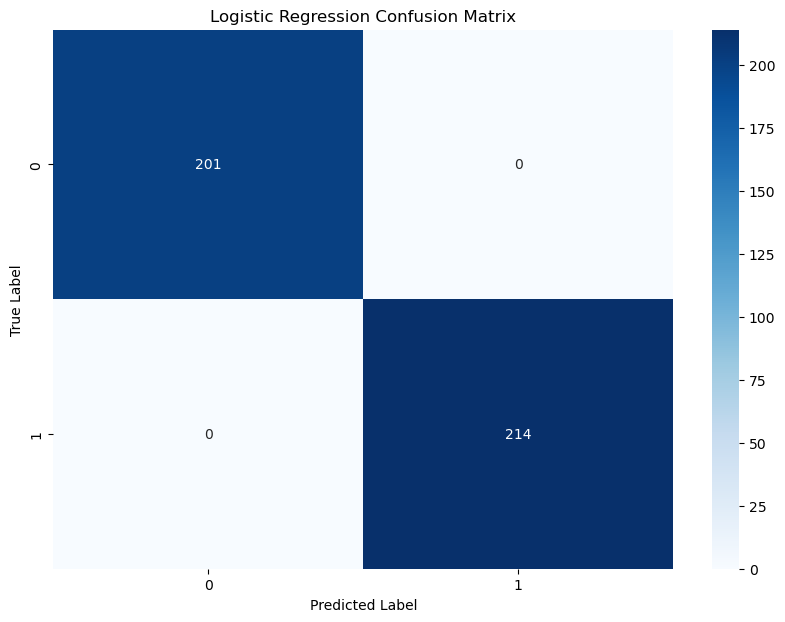

In [6]:

# Define the logistic regression model
model = LogisticRegression(labelCol="class", featuresCol="scaledFeatures")

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

24/06/08 13:23:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


SVM Test Accuracy = 1.00


/Users/nuno/.local/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00
Class 1.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00


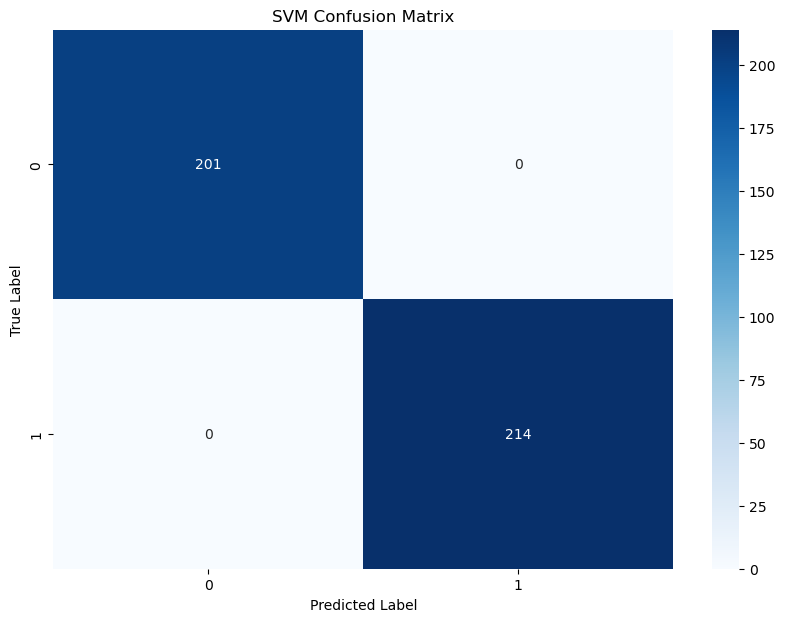

In [3]:
from pyspark.ml.classification import LinearSVC

# Define the SVM model
svm = LinearSVC(labelCol="class", featuresCol="scaledFeatures")

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, svm])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"SVM Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

Decision Tree Test Accuracy = 1.00


/Users/nuno/.local/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Class 0.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00
Class 1.0:
  Precision = 1.00
  Recall = 1.00
  F1 Score = 1.00


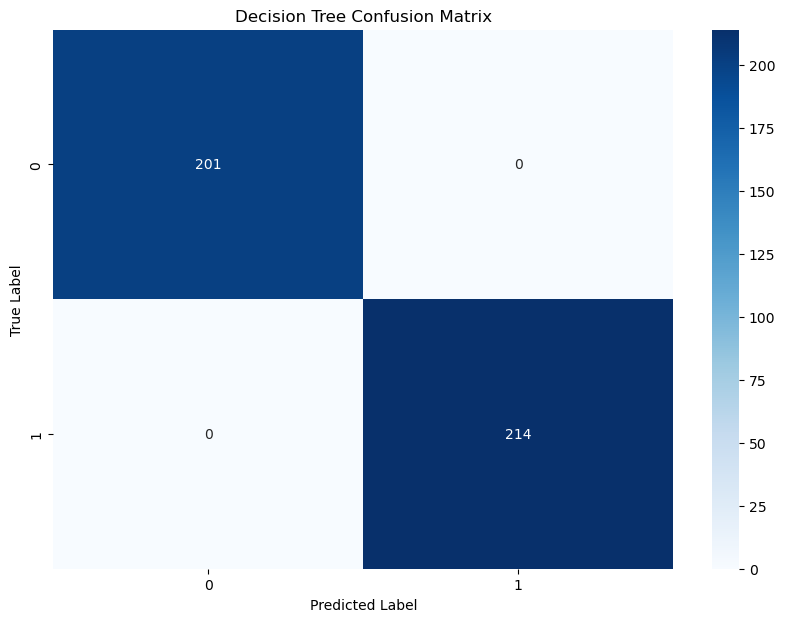

In [4]:
from pyspark.ml.classification import DecisionTreeClassifier


# Define the Decision Tree model
dt = DecisionTreeClassifier(labelCol="class", featuresCol="scaledFeatures")

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, dt])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()